In [ ]:
import numpy as np
from dataclasses import dataclass
from scipy.optimize import least_squares
from scipy import signal
import matplotlib.pyplot as plt
import os

import ipywidgets as widgets
from IPython.display import display, clear_output

# ==========================================
# FFT 기반 전달함수 추정
# ==========================================

def estimate_transfer_function(x, y, dt, f_max=None, 
                               min_input_amp=1e-6, min_H_mag=None):
    """
    x(t), y(t)로부터 FFT 기반 H(ω) = Y(ω)/X(ω) 추정.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = len(x)
    if len(y) != n:
        raise ValueError("x와 y의 길이가 같아야 합니다.")

    X = np.fft.rfft(x)
    Y = np.fft.rfft(y)
    freqs = np.fft.rfftfreq(n, dt)
    w = 2 * np.pi * freqs

    H = Y / X

    mask = np.abs(X) > min_input_amp  # 입력 신호가 충분히 큰 구간만 사용
    mask &= freqs > 0

    if f_max is not None:
        mask &= freqs <= f_max

    if min_H_mag is not None:   # H 크기가 너무 작은 구간은 버리기
        mask &= (np.abs(H) > min_H_mag)

    if not np.any(mask):
        raise RuntimeError("유효한 주파수 구간이 없습니다.")
    

    return freqs[mask], w[mask], H[mask]


# ==========================================
# 1·2차 표준형 전달함수
# ==========================================

def H_1st_LP(w, K, wc):
    return K / (1 + 1j*w/wc)

def H_1st_HP(w, K, wc):
    return K * (1j*w/wc) / (1 + 1j*w/wc)

def _den(w, w0, Q):
    return (1j*w)**2 + (w0/Q)*(1j*w) + w0**2

def H_2nd_LP(w, K, w0, Q):
    return K * (w0**2) / _den(w, w0, Q)

def H_2nd_HP(w, K, w0, Q):
    return K * ((1j*w)**2) / _den(w, w0, Q)

def H_2nd_BP(w, K, w0, Q):
    return K * ((w0/Q)*(1j*w)) / _den(w, w0, Q)

def H_2nd_BR(w, K, w0, Q):
    return K * ((1j*w)**2 + w0**2) / _den(w, w0, Q)

# ==========================================
# 2차 LP / HP 컷오프 계산 
def cutoff_2nd_LP(w0, Q):
    term = (np.sqrt(1 + 4*(Q**4)) - 1) / (2*Q*Q)
    wc = w0 * np.sqrt(term)
    fc = wc / (2*np.pi)
    return wc, fc

def cutoff_2nd_HP(w0, Q):
    term = (1 + 2*(Q**2) + np.sqrt(1 + 4*(Q**2))) / (2*Q*Q)
    wc = w0 * np.sqrt(term)
    fc = wc / (2*np.pi)
    return wc, fc


# ==========================================
# 피팅
# ==========================================

@dataclass
class FitResult:
    name: str
    params: dict
    mse: float

def fit_complex(w, H_meas, func, p0, bounds):
    """
    복소 전달함수 H_meas(w)에 대해
    H_pred(w, p)를 least_squares로 피팅.
    """
    def residual(p):
        H_pred = func(w, *p)
        diff = H_pred - H_meas
        return np.concatenate([diff.real, diff.imag])

    res = least_squares(residual, p0, bounds=bounds)
    p = res.x
    H_pred = func(w, *p)
    mse = np.mean(np.abs(H_pred - H_meas)**2)
    return p, mse


# ==========================================
# confidence 분석
# ==========================================

def analyze_confidence(models, ambiguous_ratio=0.1):
    """
    models: dict[str, FitResult]
    반환:
      { "best": best_result,
        "top3": [FitResult, ...],
        "rel_gap_12": 상대 차이,
        "confidence": 0~1,
        "ambiguous": True/False }
    """
    results = sorted(models.values(), key=lambda r: r.mse)
    best = results[0]
    top3 = results[:3]

    mse_best = best.mse
    if len(results) > 1:
        mse_second = results[1].mse
        rel_gap_12 = (mse_second - mse_best) / (mse_best + 1e-12)
    else:
        mse_second = None
        rel_gap_12 = float("inf")

    raw_conf = max(0.0, min(1.0, rel_gap_12 / 0.5))  # 50% 차이면 ~1
    ambiguous = (rel_gap_12 < ambiguous_ratio)

    return {
        "best": best,
        "top3": top3,
        "rel_gap_12": rel_gap_12,
        "confidence": raw_conf,
        "ambiguous": ambiguous,
    }


# ==========================================
# 필터 모델 결정 + Bode 플롯
# ==========================================

def identify_order12_filter(x, y, dt, f_max=None, show_bode=True):
    """
    x(t) → 시스템 → y(t) 에 대해
    1차/2차 표준형 필터(LP, HP, BP, BR) 중 하나로 피팅.
    """
    freqs, w, H_meas = estimate_transfer_function(x, y, dt, f_max=f_max,
                                                  min_input_amp=1e-6, min_H_mag=0.0
    )
    mag = np.abs(H_meas)
    K0 = np.median(mag) if np.median(mag) > 0 else 1.0
    w_mid = np.median(w)
    wc0 = w_mid if w_mid > 0 else 1e3
    idx_pk  = np.argmax(mag)     # 최대 |H| 위치
    idx_min = np.argmin(mag)     # 최소 |H| (노치) 위치
    w_peak  = w[idx_pk]  if w[idx_pk]  > 0 else 1e3
    w_notch = w[idx_min] if w[idx_min] > 0 else 1e3
    Q0 = 1.0

    models = {}
    
    # 1st models
    p0 = [K0, wc0]
    b1 = ([0, 1e-3], [1e3*K0, 1e9])
    # 1st LP
    p, mse = fit_complex(w, H_meas, H_1st_LP, p0, b1)
    models["1st_LP"] = FitResult(
        "1st_LP",
        {"K": float(p[0]), "wc": float(p[1])},
        float(mse)
    )
    # 1st HP
    p, mse = fit_complex(w, H_meas, H_1st_HP, p0, b1)
    models["1st_HP"] = FitResult(
        "1st_HP",
        {"K": float(p[0]), "wc": float(p[1])},
        float(mse)
    )

    # 2nd models
    b2 = ([0, 1e-3, 0.1], [1e3*K0, 1e9, 100])
    for name, func in {
        "2nd_LP": H_2nd_LP,
        "2nd_HP": H_2nd_HP,
        "2nd_BP": H_2nd_BP,
        "2nd_BR": H_2nd_BR,
    }.items():
        if name == "2nd_BR":
            w0_init = w_notch      # 노치는 최소값 기준
        else:
            w0_init = w_peak       # 나머지는 최대값 기준 (지금과 동일)

        p0 = [K0, w0_init, Q0]
        p, mse = fit_complex(w, H_meas, func, p0, b2)
        models[name] = FitResult(
            name,
            {"K": float(p[0]), "w0": float(p[1]), "Q": float(p[2])},
            float(mse)
        )

    best = min(models.values(), key=lambda r: r.mse)
    conf_info = analyze_confidence(models, ambiguous_ratio=0.1)

    if show_bode:
        func_map = {
            "1st_LP": H_1st_LP,
            "1st_HP": H_1st_HP,
            "2nd_LP": H_2nd_LP,
            "2nd_HP": H_2nd_HP,
            "2nd_BP": H_2nd_BP,
            "2nd_BR": H_2nd_BR,
        }
        model_func = func_map[best.name]
        pvals = [best.params[k] for k in best.params.keys()]

        mag_meas = 20*np.log10(np.abs(H_meas) + 1e-12)
        phase_meas = np.unwrap(np.angle(H_meas))

        f_min_meas = np.min(freqs)
        f_max_meas = np.max(freqs)

        f_min = max(f_min_meas / 50, 1e0)   # 최소 1 Hz
        f_max = f_max_meas * 50

        f_fit = np.logspace(np.log10(f_min), np.log10(f_max), 500)
        w_fit = 2*np.pi*f_fit
        H_fit = model_func(w_fit, *pvals)
        mag_fit = 20*np.log10(np.abs(H_fit) + 1e-12)
        phase_fit = np.unwrap(np.angle(H_fit))

        # ===== Magnitude =====
        plt.figure()
        plt.semilogx(freqs, mag_meas, 'o', label="Measured")
        plt.semilogx(f_fit, mag_fit, '-', label=f"Best: {best.name}")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude [dB]")
        plt.grid(True, which="both")

        # w0, wc 표시용
        ymin = min(np.nanmin(mag_meas), np.nanmin(mag_fit))
        ymax = max(np.nanmax(mag_meas), np.nanmax(mag_fit))

        # 1차: fc(=wc/2π) 표시
        if best.name in ["1st_LP", "1st_HP"]:
            wc = best.params["wc"]
            fc = wc / (2*np.pi)
            plt.axvline(fc, linestyle="--", alpha=0.7)
            plt.text(fc, ymax, "fc", rotation=90,
                     va="bottom", ha="right", fontsize=8)

        # 2차: f0는 항상 표시, 2nd LP/HP면 fc도 추가 표시
        if best.name in ["2nd_LP", "2nd_HP", "2nd_BP", "2nd_BR"]:
            w0 = best.params["w0"]
            Q  = best.params["Q"]
            f0 = w0 / (2*np.pi)
            plt.axvline(f0, linestyle="--", alpha=0.7)
            plt.text(f0, ymax, "f0", rotation=90,
                     va="bottom", ha="left", fontsize=8)

            if best.name == "2nd_LP":
                wc2, fc2 = cutoff_2nd_LP(w0, Q)
                plt.axvline(fc2, linestyle=":", alpha=0.7)
                plt.text(fc2, ymin, "fc", rotation=90,
                         va="bottom", ha="right", fontsize=8)
            elif best.name == "2nd_HP":
                wc2, fc2 = cutoff_2nd_HP(w0, Q)
                plt.axvline(fc2, linestyle=":", alpha=0.7)
                plt.text(fc2, ymin, "fc", rotation=90,
                         va="bottom", ha="right", fontsize=8)

        plt.ylim(ymin - 5, ymax + 5)
        plt.legend()
        plt.title("Bode magnitude")

        # ===== Phase =====
        plt.figure()
        plt.semilogx(freqs, phase_meas, 'o', label="Measured")
        plt.semilogx(f_fit, phase_fit, '-', label=f"Best: {best.name}")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Phase [rad]")
        plt.grid(True, which="both")
        plt.legend()
        plt.title("Phase")

        plt.show()

    return best, conf_info, models


# ==========================================
# 4-1) 파라미터 포맷팅
# ==========================================

def format_filter_params(res: FitResult) -> str:
    """
    FitResult → 사람이 보기 좋은 문자열.
    1st: K, wc, fc
    2nd: K, w0, f0, Q
    """
    n = res.name
    p = res.params

    if n in ["1st_LP", "1st_HP"]:
        K  = p["K"]
        wc = p["wc"]
        fc = wc / (2*np.pi)
        return (
            f"K  = {K:.4f}\n"
            f"wc = {wc:.4e} rad/s\n"
            f"fc = {fc:.4e} Hz  (cutoff)"
        )
    elif n in ["2nd_LP", "2nd_HP", "2nd_BP", "2nd_BR"]:
        K  = p["K"]
        w0 = p["w0"]
        Q  = p["Q"]
        f0 = w0 / (2*np.pi)
        return (
            f"K  = {K:.4f}\n"
            f"w0 = {w0:.4e} rad/s\n"
            f"f0 = {f0:.4e} Hz  (center)\n"
            f"Q  = {Q:.4f}"
        )
    else:
        return "params = " + ", ".join(f"{k}={v:.4e}" for k, v in p.items())


# ==========================================
# 5) RLC 매핑
# ==========================================

def map_to_RLC(best, C_choice_1st=1e-9, C_choice_2nd=1e-9):
    """
    1st_LP, 1st_HP -> RC
    2nd_LP, 2nd_HP, 2nd_BP, 2nd_BR -> 직렬 RLC
    """
    name = best.name
    p = best.params

    if name in ["1st_LP", "1st_HP"]:
        wc = p["wc"]
        C = C_choice_1st
        R = 1/(wc*C)
        return {"type": name, "R": R, "L": None, "C": C}

    K, w0, Q = p["K"], p["w0"], p["Q"]
    C = C_choice_2nd
    L = 1/(w0**2 * C)
    R = w0*L/Q   # series RLC

    return {"type": name, "R": R, "L": L, "C": C}


# ==========================================
# 6) 파형 생성 유틸 
# ==========================================

def generate_component(t, wtype, A, f=None, phase_deg=0.0, t0_step=0.0):
    """
    단일 파형 생성:
      wtype: 'sin', 'step' 만 지원
        - sin : A * sin(2π f t + phase)
        - step: t >= t0_step 일 때 A, 그 전은 0
    """
    wtype = wtype.lower()
    phase = np.deg2rad(phase_deg)

    if wtype == "sin":
        if f is None:
            raise ValueError("sin 파형에는 주파수 f가 필요.")
        return A * np.sin(2*np.pi*f*t + phase)

    elif wtype == "step":
        return A * (t >= t0_step).astype(float)

    else:
        raise ValueError("지원하지 않는 파형 타입")

# ==========================================
# 7) CSV 로드 + 시간축 정렬
# ==========================================

def load_csv_tx(filename):
    """
    x용 CSV: t, x  (첫 줄에 헤더 t,x 있는 형식)
    """
    if not os.path.exists(filename):
        raise FileNotFoundError(f"파일 없음: {filename}")
    data = np.loadtxt(filename, delimiter=",", skiprows=1)
    if data.ndim == 1 or data.shape[1] < 2:
        raise ValueError("CSV는 최소 두 열(t, x)이 필요.")
    t = data[:, 0]
    x = data[:, 1]
    dt = t[1] - t[0]
    return t, x, dt

def load_csv_ty(filename):
    """
    y용 CSV: t, y  (첫 줄에 헤더 t,y 있는 형식)
    """
    if not os.path.exists(filename):
        raise FileNotFoundError(f"파일 없음: {filename}")
    data = np.loadtxt(filename, delimiter=",", skiprows=1)
    if data.ndim == 1 or data.shape[1] < 2:
        raise ValueError("CSV는 최소 두 열(t, y)이 필요.")
    t = data[:, 0]
    y = data[:, 1]
    dt = t[1] - t[0]
    return t, y, dt

def align_xy_by_interpolation(t_x, x, t_y, y):
    """
    서로 다른 시간축(t_x, t_y)을 가진 x, y를
    공통 시간축으로 보간해서 맞춰줌.
    """
    t_x = np.asarray(t_x)
    t_y = np.asarray(t_y)
    x   = np.asarray(x)
    y   = np.asarray(y)

    t_start = max(t_x[0], t_y[0])
    t_end   = min(t_x[-1], t_y[-1])

    if t_start >= t_end:
        raise ValueError("x와 y의 공통 시간 구간이 없습니다.")

    dt_x = np.mean(np.diff(t_x))
    dt_y = np.mean(np.diff(t_y))
    dt_common = min(dt_x, dt_y)

    t_common = np.arange(t_start, t_end, dt_common)

    x_common = np.interp(t_common, t_x, x)
    y_common = np.interp(t_common, t_y, y)

    return t_common, x_common, y_common, dt_common


# ==========================================
# 8) UI 
# ==========================================

def run_full_widget_ui():
    """
    모드:
      - CSV 모드: x,y 둘 다 CSV (실험 데이터)
      - Wave 모드: x,y 둘 다 합성 파형 (테스트용)
    """
    style = {'description_width': '90px'}

    # 메인 모드: CSV / Wave
    main_mode = widgets.Dropdown(
        options=[('CSV (실험 데이터)', 'csv'),
                 ('Wave (테스트용 합성)', 'wave')],
        value='csv',
        description='Mode',
        style=style,
    )

    fs_w = widgets.FloatText(
        value=50000.0,
        description='fs [Hz]',
        style=style
    )

    # CSV 파일 이름
    x_csv_name = widgets.Text(
        value='x_input.csv',
        description='x CSV',
        style=style
    )
    y_csv_name = widgets.Text(
        value='y_output.csv',
        description='y CSV',
        style=style
    )

    # Wave 파라미터 (x)
    x_type = widgets.Dropdown(
        options=[('sin', 'sin'), ('step', 'step')],
        value='sin',
        description='x type',
        style=style
    )
    x_A = widgets.FloatText(value=1.0, description='x A', style=style)
    x_f = widgets.FloatText(value=1000.0, description='x f[Hz]', style=style)
    x_phase = widgets.FloatText(value=0.0, description='x phase', style=style)
    x_t0 = widgets.FloatText(value=0.0, description='x t0', style=style)

    # Wave 파라미터 (y)
    y_type = widgets.Dropdown(
        options=[('sin', 'sin'), ('step', 'step')],
        value='sin',
        description='y type',
        style=style
    )
    y_A = widgets.FloatText(value=0.5, description='y A', style=style)
    y_f = widgets.FloatText(value=1000.0, description='y f[Hz]', style=style)
    y_phase = widgets.FloatText(value=-45.0, description='y phase', style=style)
    y_t0 = widgets.FloatText(value=0.0, description='y t0', style=style)

    run_btn = widgets.Button(
        description="Run identification",
        button_style="success"
    )
    out = widgets.Output()

    def on_run_clicked(_):
        with out:
            clear_output()
            try:
                mode = main_mode.value

                if mode == 'csv':
                    # x,y 둘 다 CSV → 시간축 보간 정렬
                    t_x, x, dt_x = load_csv_tx(x_csv_name.value)
                    t_y, y, dt_y = load_csv_ty(y_csv_name.value)
                    print(f"x CSV: N={len(t_x)}, dt={dt_x:.3e}")
                    print(f"y CSV: N={len(t_y)}, dt={dt_y:.3e}")

                    t, x_use, y_use, dt = align_xy_by_interpolation(t_x, x, t_y, y)
                    print(f"\n[CSV 모드] 공통 구간: N={len(t)}, dt={dt:.3e}")

                elif mode == 'wave':
                    # x,y 둘 다 합성 파형
                    fs = fs_w.value
                    dt = 1.0 / fs

                    freqs = []
                    if x_type.value != 'step' and x_f.value > 0:
                        freqs.append(x_f.value)
                    if y_type.value != 'step' and y_f.value > 0:
                        freqs.append(y_f.value)

                    if freqs:
                        f_min = min(freqs)
                        duration = 30.0 / f_min
                    else:
                        duration = 0.01  # 둘 다 step이면 10 ms

                    t = np.arange(0.0, duration, dt)
                    x_use = generate_component(
                        t,
                        x_type.value,
                        x_A.value,
                        f=(x_f.value if x_type.value != 'step' else None),
                        phase_deg=x_phase.value,
                        t0_step=x_t0.value
                    )
                    y_use = generate_component(
                        t,
                        y_type.value,
                        y_A.value,
                        f=(y_f.value if y_type.value != 'step' else None),
                        phase_deg=y_phase.value,
                        t0_step=y_t0.value
                    )
                    print(f"\n[Wave 모드] N={len(t)}, dt={dt:.3e}, duration={duration:.3e}")

                else:
                    raise ValueError("알 수 없는 모드")

                print(f"\n✓ 최종 신호 준비 완료: N={len(t)}, dt={dt:.3e}")

                # ==========================================
                # 입력/출력 파형 플롯
                # ==========================================
                t_ms = t * 1e3  # ms 단위로 보는 게 눈에 편함
                fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
                # ---- 입력 ----
                axes[0].plot(t_ms, x_use, linewidth=0.8)
                axes[0].set_ylabel("x(t)")
                axes[0].set_title("Input & Output Waveforms (full range)")
                axes[0].grid(True)
                # ---- 출력 ----
                axes[1].plot(t_ms, y_use, linewidth=0.8, color="C1")
                axes[1].set_xlabel("Time [ms]")
                axes[1].set_ylabel("y(t)")
                axes[1].grid(True)
                plt.tight_layout()
                plt.show()
 
                # ----- 필터 식별 -----
                best, conf_info, models = identify_order12_filter(
                    x_use, y_use, dt,
                    f_max=None,
                    show_bode=True
                )
                best_rlc = map_to_RLC(best, C_choice_1st=1e-9, C_choice_2nd=1e-9)

                print("\n=== 최종 선택된 모델 (Best) ===")
                print(f"필터 타입: {best.name}")
                print("  [파라미터]")
                for line in format_filter_params(best).splitlines():
                    print("   ", line)

                # 2nd LP/HP면 컷오프도 출력
                if best.name == "2nd_LP":
                    w0 = best.params["w0"]
                    Q  = best.params["Q"]
                    wc2, fc2 = cutoff_2nd_LP(w0, Q)
                    print(f"  [2nd LP cutoff]")
                    print(f"    wc = {wc2:.4e} rad/s")
                    print(f"    fc = {fc2:.4e} Hz")
                elif best.name == "2nd_HP":
                    w0 = best.params["w0"]
                    Q  = best.params["Q"]
                    wc2, fc2 = cutoff_2nd_HP(w0, Q)
                    print(f"  [2nd HP cutoff]")
                    print(f"    wc = {wc2:.4e} rad/s")
                    print(f"    fc = {fc2:.4e} Hz")

                print("  [RLC 값]")
                print(f"    R = {best_rlc['R']:.4e}")
                if best_rlc['L'] is not None:
                    print(f"    L = {best_rlc['L']:.4e}")
                print(f"    C = {best_rlc['C']:.4e}")

                print(f"  Confidence score = {conf_info['confidence']:.3f}")
                if conf_info["ambiguous"]:
                    print("  (주의: 1위와 2위 모델의 MSE 차이가 작음.)")

                print("\n=== 상위 3개 후보 모델 (Top-3) ===")
                top3 = conf_info["top3"]
                for rank, res in enumerate(top3, start=1):
                    rlc_i = map_to_RLC(res, C_choice_1st=1e-9, C_choice_2nd=1e-9)
                    print(f"[{rank}위] {res.name}")
                    print(f"    MSE = {res.mse:.3e}")
                    print("    [파라미터]")
                    for line in format_filter_params(res).splitlines():
                        print("      ", line)
                    # 각 후보에 대해서도 컷오프가 있는 타입이면 표시 가능
                    if res.name == "2nd_LP":
                        w0 = res.params["w0"]; Q = res.params["Q"]
                        _, fc2 = cutoff_2nd_LP(w0, Q)
                        print(f"      (2nd LP fc ≈ {fc2:.4e} Hz)")
                    elif res.name == "2nd_HP":
                        w0 = res.params["w0"]; Q = res.params["Q"]
                        _, fc2 = cutoff_2nd_HP(w0, Q)
                        print(f"      (2nd HP fc ≈ {fc2:.4e} Hz)")
                    print("    [RLC 근사]")
                    print(f"      R ≈ {rlc_i['R']:.4e}")
                    if rlc_i['L'] is not None:
                        print(f"      L ≈ {rlc_i['L']:.4e}")
                    print(f"      C = {rlc_i['C']:.4e}")

            except Exception as e:
                print("[에러 발생]")
                print(repr(e))

    run_btn.on_click(on_run_clicked)

    ui = widgets.VBox([
        widgets.HTML("<b>RLC 필터 식별기</b>"),
        main_mode,
        fs_w,
        widgets.HTML("<hr><b>CSV 모드에서 사용할 파일 이름</b>"),
        widgets.HBox([x_csv_name, y_csv_name]),
        widgets.HTML("<hr><b>Wave 모드: x 설정</b>"),
        widgets.HBox([x_type, x_A, x_f]),
        widgets.HBox([x_phase, x_t0]),
        widgets.HTML("<b>Wave 모드: y 설정</b>"),
        widgets.HBox([y_type, y_A, y_f]),
        widgets.HBox([y_phase, y_t0]),
        run_btn,
        out
    ])

    display(ui)

run_full_widget_ui()


정렬된 신호: N=4999, dt=1.000e-05
MSE( y_model , y_meas ) = 7.501e-05


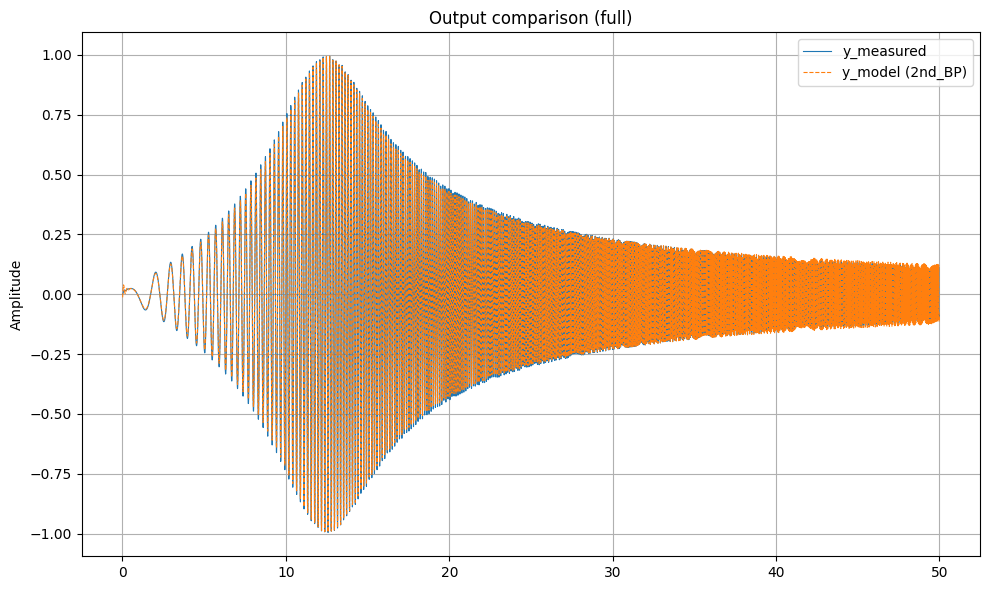

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1) 주파수 영역에서 모델 통과시켜서 y_model(t) 만드는 함수
# ---------------------------------------------------
def simulate_model_output(x, dt, model_name, **params):
    """
    x(t), dt, 모델 이름, 파라미터(K, wc / w0, Q)를 넣으면
    y_model(t)을 FFT 기반으로 계산해서 돌려줌.
    """
    x = np.asarray(x, dtype=float)
    n = len(x)

    X = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(n, dt)
    w = 2 * np.pi * freqs

    # ---- 모델 선택 ----
    if model_name == "1st_LP":
        H = H_1st_LP(w, params["K"], params["wc"])
    elif model_name == "1st_HP":
        H = H_1st_HP(w, params["K"], params["wc"])
    elif model_name == "2nd_LP":
        H = H_2nd_LP(w, params["K"], params["w0"], params["Q"])
    elif model_name == "2nd_HP":
        H = H_2nd_HP(w, params["K"], params["w0"], params["Q"])
    elif model_name == "2nd_BP":
        H = H_2nd_BP(w, params["K"], params["w0"], params["Q"])
    elif model_name == "2nd_BR":
        H = H_2nd_BR(w, params["K"], params["w0"], params["Q"])
    else:
        raise ValueError(f"알 수 없는 model_name: {model_name}")

    # ---- 모델 통과 ----
    Y_model = H * X
    y_model = np.fft.irfft(Y_model, n=n)  # 시간 영역으로 복원 (실수부)
    return y_model


# ---------------------------------------------------
# 2) 사용자 입력 + 시뮬레이션 + 플롯
# ---------------------------------------------------

# (1) 테스트에 사용할 x,y CSV 파일 이름 입력
x_file = "x_chirp.csv"          # 입력 CSV (t,x)
y_file = "y_bp_chirp.csv"   # 출력 CSV (t,y_meas)

# (2) CSV에서 데이터 읽고, 공통 시간축으로 정렬
t_x, x_raw, dt_x = load_csv_tx(x_file)
t_y, y_raw, dt_y = load_csv_ty(y_file)

t, x, y_meas, dt = align_xy_by_interpolation(t_x, x_raw, t_y, y_raw)
print(f"정렬된 신호: N={len(t)}, dt={dt:.3e}")

# (3) 필터 모델, 파라미터 입력
model_name = "2nd_BP"
K  = 0.9907
f0 = 4.9953e3          # Hz
w0 = 2*np.pi*f0   # rad/s
Q  = 2.0987

y_model = simulate_model_output(
    x, dt,
    model_name,
    K=K, w0=w0, Q=Q
)

# (4) 간단히 MSE 계산
mse = np.mean((y_model - y_meas)**2)
print(f"MSE( y_model , y_meas ) = {mse:.3e}")

# (5) 플롯으로 비교
t_ms = t * 1e3

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

axes.plot(t_ms, y_meas, label="y_measured", linewidth=0.8)
axes.plot(t_ms, y_model, "--", label=f"y_model ({model_name})", linewidth=0.8)
axes.set_title("Output comparison (full)")
axes.set_ylabel("Amplitude")
axes.legend()
axes.grid(True)


plt.tight_layout()
plt.show()
